In [681]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [682]:
# notes: Constant BCs and Sources go on RHS. Diffusion terms go in matrix

In [683]:
class Point_Source(object):
    def __init__(self, _node, _value):
        self.node = _node
        self.value = _value

In [684]:
class Continuous_Source(object):
    def __init__(self, _x_upper, _x_lower, _y_upper, _y_lower, _strength):
        self.x_upper = _x_upper
        self.x_lower = _x_lower
        self.y_upper = _y_upper
        self.y_lower = _y_lower
        self.strength = _strength

In [685]:
class Grid(object):
    def __init__(self, _Lx=1, _Ly=1, _point_sources=[], _continuous_sources=[],
                 _left_BC=0, _right_BC=1, _type_one_BCs_on=True, _num_nodes_per_side = 4):
        self.num_nodes_per_side = _num_nodes_per_side
        self.num_elements = ((_num_nodes_per_side-1)**2)*2
        self.num_nodes = _num_nodes_per_side*_num_nodes_per_side
        self.elements = list(range(1,self.num_elements+1))
        self.nodes = list(range(1,self.num_nodes+1))
        # we make the node values list one longer than it needs to be to not 
        # have to deal with 1 indexing instead of 0 indexing
        self.node_values = [0] * (self.num_nodes+1)
        self.left_edge_nodes = []
        self.right_edge_nodes = []
        if _type_one_BCs_on:
            for i in range(0,_num_nodes_per_side):
                self.left_edge_nodes.append(i*_num_nodes_per_side+1)
                self.right_edge_nodes.append((i+1)*_num_nodes_per_side)
        self.point_sources = _point_sources
        self.continuous_sources = _continuous_sources
        self.Lx = _Lx
        self.Ly = _Ly
        self.left_BC = _left_BC
        self.right_BC = _right_BC
        self.elemental_area = (_Lx*_Ly)/len(self.elements)

    # We make sure to return these nodes sorted in counter clockwise order
    def nodes_associated_with_element(self, element):
        square = math.floor((float(element)+1.0)/2.0)
        row = math.floor((square-.5)/(self.num_nodes_per_side-1))
        is_upper_triangle = element%2
        lower_left_node = int(square + row)
        upper_right_node = lower_left_node + self.num_nodes_per_side + 1
        third_node = lower_left_node + 1
        if not is_upper_triangle:
            return [lower_left_node,third_node,upper_right_node]
        else:
            third_node = upper_right_node - 1
            return [lower_left_node,upper_right_node,third_node]
    
    def row(self, node):
        return (math.floor((node-1)/self.num_nodes_per_side))
    
    def column(self, node):
        return ((node-1)%self.num_nodes_per_side)

    def node_y(self, node):
        return self.Ly * self.row(node)/(self.num_nodes_per_side-1)
    
    def node_x(self, node):
        return self.Ly * self.column(node)/(self.num_nodes_per_side-1)

    def empty_matrix(self):
        matrix = []
        for _ in self.nodes:
            matrix.append([0]*self.num_nodes)
        return matrix

    # TODO calculate this
    def percent_overlap(continuous_source, element):
        return 1
    
    # need to adjust this for how much of the element is being overlapped by the source
    # For now we assume the continuous source is a constant
    # This can go in the vector not the matrix
    def calculate_continuous_source_term(self, element, continuous_source):
        return self.elemental_area * continuous_source.strength * self.percent_overlap(element, continuous_source)
    
    def assemble_right_hand_side(self):
        vector = [0] * len(self.nodes)
        # add type 1 BCs
        for node in self.left_edge_nodes:
            vector[node-1] = self.left_BC
        for node in self.right_edge_nodes:
            vector[node-1] = self.right_BC
        # add point sources
        for point_source in self.point_sources:
            vector[point_source.node-1] = point_source.value 
        # for element in self.elements:
        #     for continuous_source in self.continuous_sources:
        #         vector[element] += self.calculate_continuous_source_term(element, continuous_source)
        return vector
    
    # # TODO for each case determine to use dx or dy for T
    # def calculate_diffusion_term(self, node_1, node_2, element):
    #     NUM_CELLS_PER_ROW = self.num_nodes_per_side-1
    #     dx = self.Lx/NUM_CELLS_PER_ROW
    #     if node_1 == node_2:
    #         return (dx**2.0)/(2.0*self.elemental_area**2.0)
    #     else:
    #         if self.nodes_are_seperated_by_long_edge(node_1, node_2):
    #             return 0
    #         else:
    #             return -(dx**2.0)/(4.0*self.elemental_area**2.0)
            
    def relative_element_node(self, element_nodes, index):
        return element_nodes[index%3]
    
    # TODO ADD variable T
    def calculate_diffusion_term(self, i, j, element_nodes):
        term_1 = (self.node_y(element_nodes[(i+1)%3]) - self.node_y(element_nodes[(i+2)%3]))/(2*self.elemental_area)
        term_2 = (self.node_y(element_nodes[(j+1)%3]) - self.node_y(element_nodes[(j+2)%3]))/(2*self.elemental_area)
        term_3 = (self.node_x(element_nodes[(i+2)%3]) - self.node_x(element_nodes[(i+1)%3]))/(2*self.elemental_area)
        term_4 = (self.node_x(element_nodes[(j+2)%3]) - self.node_x(element_nodes[(j+1)%3]))/(2*self.elemental_area)
        return term_1*term_2+term_3*term_4

    def assemble_matrix(self):
        matrix = self.empty_matrix()
        # do elemental integrals
        for element in self.elements:
            element_nodes = self.nodes_associated_with_element(element)
            for i in range(0,len(element_nodes)):
                for j in range(0,len(element_nodes)):
                    contribution = self.calculate_diffusion_term(i, j, element_nodes)
                    matrix[element_nodes[i]-1][element_nodes[j]-1] += contribution
            # for node_1 in element_nodes:
            #     for node_2 in element_nodes:
            #         contribution = self.calculate_diffusion_term(node_1, node_2, element)
            #         matrix[node_1-1][node_2-1] += contribution
        # add type one BCs
        for node in self.left_edge_nodes:
            matrix[node-1] = [0]*len(self.nodes)
            matrix[node-1][node-1] = 1
        for node in self.right_edge_nodes:
            matrix[node-1] = [0]*len(self.nodes)
            matrix[node-1][node-1] = 1
        # add type 2 BCs

        # add point source/sink terms
        for point_source in self.point_sources:
            matrix[point_source.node-1] = [0]*len(self.nodes)
            matrix[point_source.node-1][point_source.node-1] = 1
        return matrix

    def solve_system(self):
        A = self.assemble_matrix()
        b = self.assemble_right_hand_side()
        self.node_values = [0] + list(np.linalg.solve(A,b))
    
    def print_system(self):
        printing_grid = np.zeros((self.num_nodes_per_side,self.num_nodes_per_side))
        for node in self.nodes:
            node_value = self.node_values[node]
            y = self.num_nodes_per_side - 1 - math.floor((node-1)/self.num_nodes_per_side)
            x = (node-1) % self.num_nodes_per_side
            printing_grid[y][x] = node_value
        ax = sns.heatmap(printing_grid, linewidth=0.5,cmap="YlGnBu",xticklabels=[],yticklabels=[])
        plt.title("Graph of node values")
        # plt.set(xticklabels=[],yticklabels=[])
        plt.show()

        


In [686]:
grid = Grid()

In [687]:
# Nodes associated with element test
assert grid.nodes_associated_with_element(1) == [1,6,5]
assert grid.nodes_associated_with_element(2) == [1,2,6]
assert grid.nodes_associated_with_element(7) == [5,10,9]
assert grid.nodes_associated_with_element(8) == [5,6,10]

In [688]:
# Node position calculations test
assert grid.node_y(1) == 0
assert grid.node_x(1) == 0
assert grid.node_y(4) == 0
assert grid.node_x(6) == 1.0/3.0
assert grid.node_y(12) == 2.0/3.0
assert grid.node_y(16) == 1
assert grid.node_x(16) == 1

In [689]:
# print(nodes)
matrix = grid.assemble_matrix()
print(matrix)

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-9.0, 36.0, -9.0, 0, 0, -18.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -9.0, 36.0, -9.0, 0, 0, -18.000000000000004, 0.0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.0, -18.0, 0, 0, -18.0, 72.0, -18.0, 0, 0, -18.0, 0.0, 0, 0, 0, 0, 0], [0, 0.0, -18.000000000000004, 0, 0, -18.0, 72.0, -18.0, 0, 0, -18.000000000000004, 0.0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.0, -18.0, 0, 0, -18.000000000000004, 72.0, -18.000000000000004, 0, 0, -18.0, 0.0, 0], [0, 0, 0, 0, 0, 0.0, -18.000000000000004, 0, 0, -18.000000000000004, 72.0, -18.000000000000004, 0, 0, -18.000000000000004, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, -18.0, 0, 0, -9.000000000000004, 36.00000000000001, -9.000000000000004,

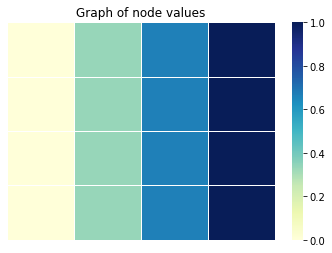

In [690]:
# Only type 1 bcs on
grid = Grid()
grid.solve_system()
grid.print_system()

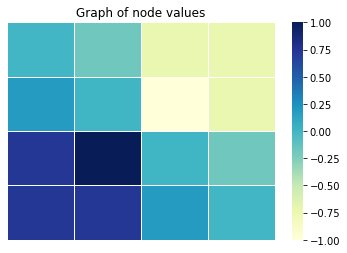

In [691]:
# Only 
point_sources =[ 
    Point_Source(_node=6,_value=1),
    Point_Source(_node=11,_value=-1)
]
grid = Grid(_point_sources=point_sources, _right_BC=0, _type_one_BCs_on = False)
grid.solve_system()
grid.print_system()

In [692]:
# # Only 
# point_sources =[ 
#     Point_Source(_node=7,_value=1),
#     # Point_Source(_node=11,_value=1)
# ]
# grid = Grid(_point_sources=point_sources, _right_BC=1, _type_one_BCs_on = True)

# grid.solve_system()
# grid.print_system()

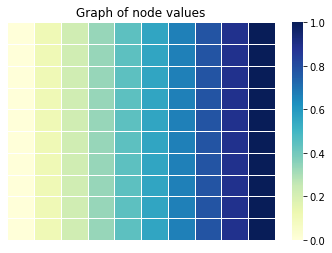

In [693]:
# Only type 1 bcs only, larger grid
grid = Grid(_num_nodes_per_side=10)
grid.solve_system()
grid.print_system()

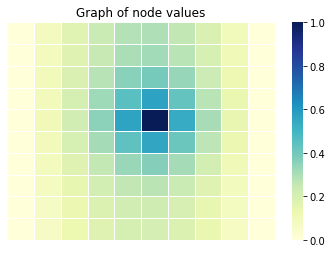

In [694]:
point_sources =[ 
    Point_Source(_node=56,_value=1),
    # Point_Source(_node=11,_value=1)
]
grid = Grid(_point_sources=point_sources, _right_BC=0, _type_one_BCs_on = True, _num_nodes_per_side=10)

grid.solve_system()
grid.print_system()

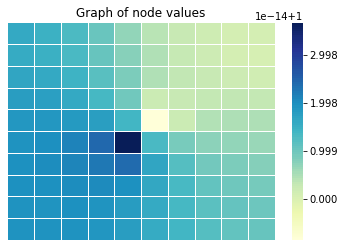

In [695]:
point_sources =[ 
    Point_Source(_node=56,_value=1),
    Point_Source(_node=45,_value=1)
]
grid = Grid(_point_sources=point_sources, _type_one_BCs_on = False, _num_nodes_per_side=10)

grid.solve_system()
grid.print_system()